### Importing The Packages

In [1]:
# Importing the liabraries
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input,Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, MobileNetV3Large
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import to_categorical
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import cv2
from tqdm import tqdm
from vit_keras import vit
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,f1_score,ConfusionMatrixDisplay
import os
import pandas as pd

# if you dont have cuda enabled gpu in your system comment the lines below
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2023-12-24 17:51:15.637067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 17:51:16.096948: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 17:51:16.985283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aamir_z/anaconda3/envs/fvgpu/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/aamir_z/anaconda3/envs/fvgpu/lib/:
2023-12-24 17:51:16.985483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Num GPUs Available:  1


2023-12-24 17:51:18.699989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-24 17:51:18.843568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-24 17:51:18.843778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Loading the dataset

In [2]:
# loading the datas
images = []
labels = []
# Location with subdirectories
path = "data_set"
# Get List of all images
files = glob.glob(path + '/**/*.jpeg', recursive=True)
# For each image
for file in  tqdm (files):
    img = cv2.imread(file)[:,:,::-1]
    img = cv2.resize(img,(224,224))
    #print(filename)
    images.append(img)
    y = file.split('/')[2]
    #print(y)
    labels.append(y)
images = np.array(images)
labels = np.array(labels)

100%|██████████| 15000/15000 [02:32<00:00, 98.14it/s] 


### Data Analysis

In [3]:
# shape of images
print("Shape of Data = ", images.shape)

Shape of Data =  (15000, 224, 224, 3)


In [4]:
print("Shape of labels = ", labels.shape)

Shape of labels =  (15000,)


labels
colon_aca    3000
colon_n      3000
lung_scc     3000
lung_aca     3000
lung_n       3000
Name: count, dtype: int64


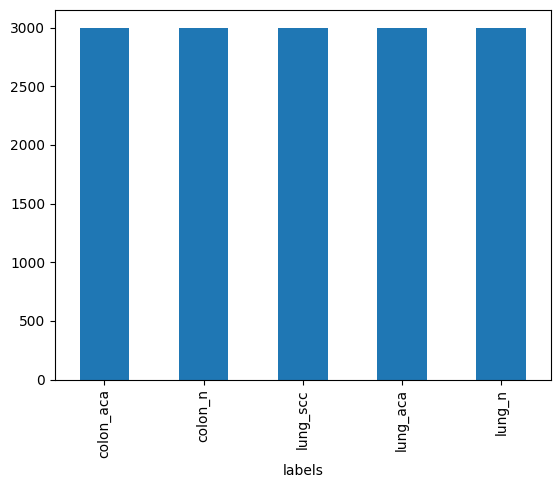

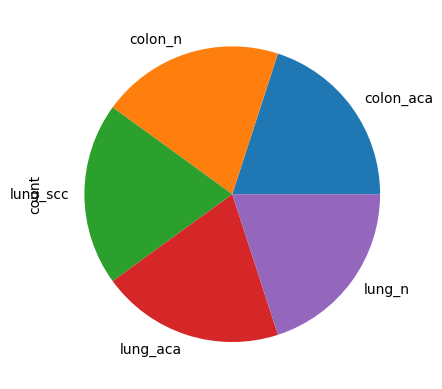

In [5]:
# storing the labels in the data frame
labels_df = pd.DataFrame(labels,columns=['labels'])

print(labels_df['labels'].value_counts())
plt.figure()
labels_df['labels'].value_counts().plot.bar()
plt.show()
plt.figure()
labels_df['labels'].value_counts().plot.pie()
plt.show()

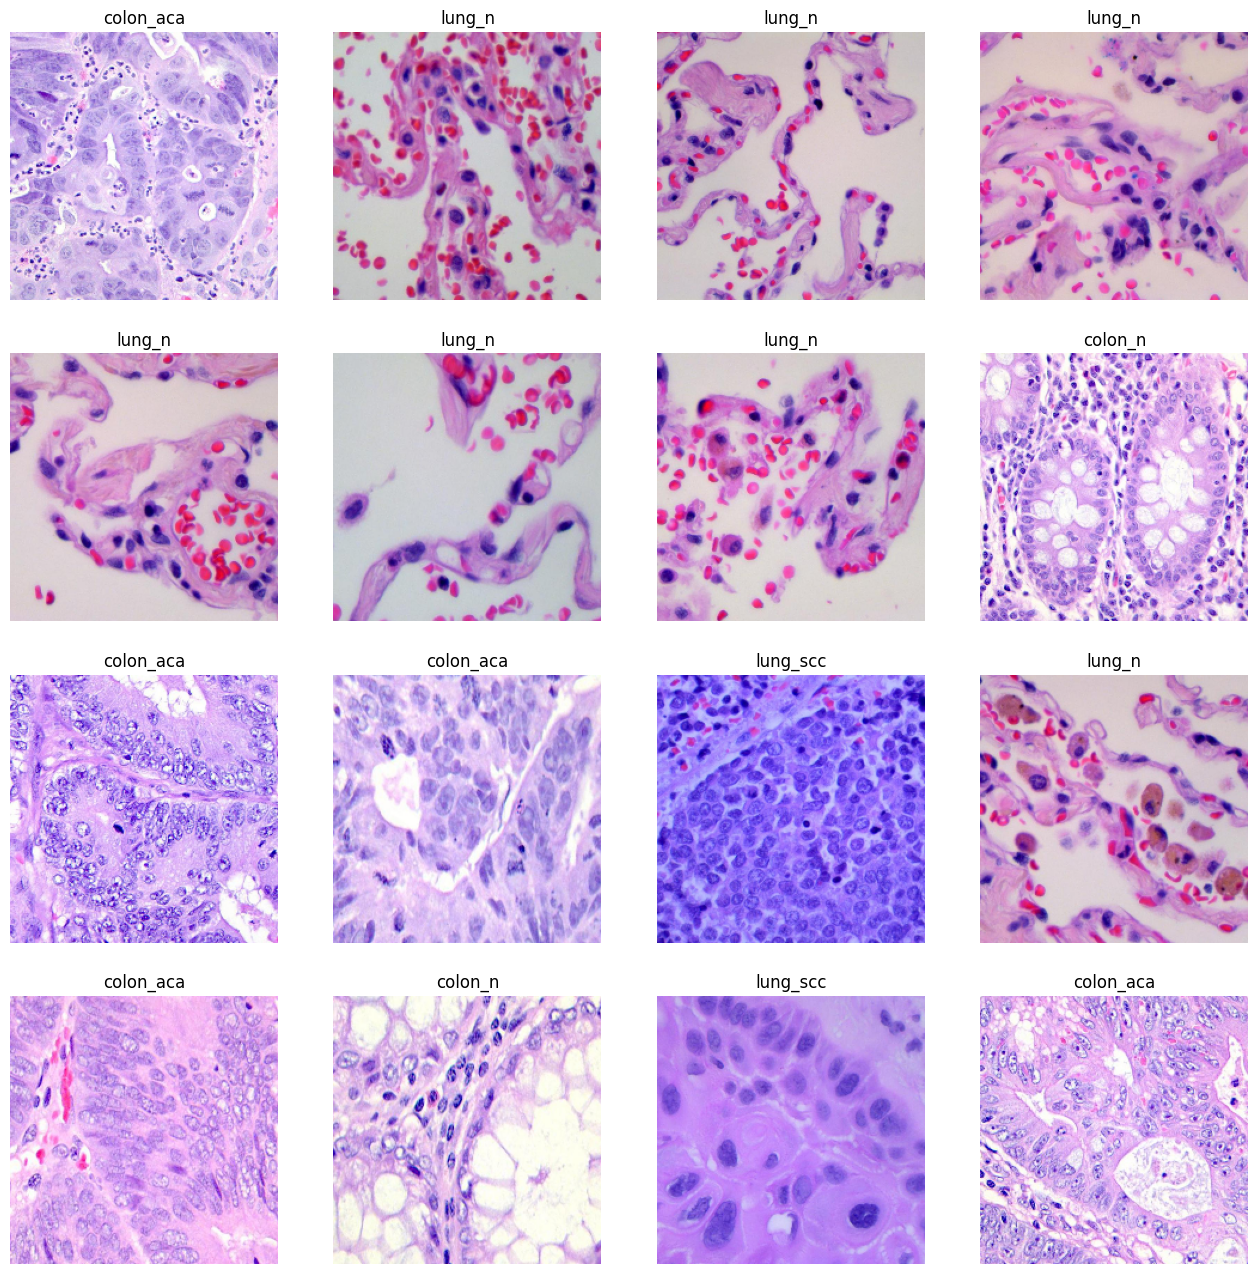

In [6]:
# This code will help you in visualizing mages
#np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, images.shape[0], 1))
    plt.title(str(labels[index]))
    plt.imshow(images[index])
    plt.axis('off')

In [7]:
# loabel encoding of categorical features
le = LabelEncoder()
labels = le.fit_transform(labels)

# one hot encoding to feed it into model.
labels =to_categorical(labels)


In [8]:
#### Splitting the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


### Deep Learning Models


In [9]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
accuracy_loss_plot = PlotLearning()

### Model 1 MobileNet

In [10]:
### initializing the model 
base_model = MobileNetV3Large(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])

2023-12-24 17:53:54.628441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 17:53:54.629503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-24 17:53:54.629807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-24 17:53:54.629990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [11]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

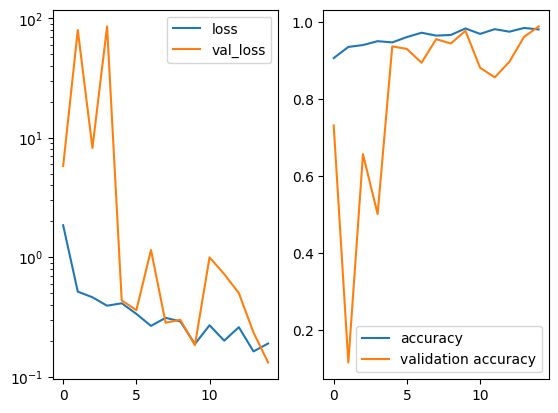

1200/1200 [==============================] - 51s 42ms/step - loss: 0.1898 - accuracy: 0.9811 - val_loss: 0.1318 - val_accuracy: 0.9887


In [12]:
#train the model with min batch size as 32 
history=model.fit(X_train,y_train,validation_split=0.2,epochs=15,batch_size=8, callbacks=accuracy_loss_plot)

#### Model Evaluation

In [13]:
### train performace 

In [14]:
y_pred = model.predict(X_train,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

2023-12-24 18:06:19.252447: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1806336000 exceeds 10% of free system memory.
2023-12-24 18:06:21.203505: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1806336000 exceeds 10% of free system memory.


1500/1500 [==============================] - 18s 11ms/step


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2401
           1       0.99      1.00      0.99      2364
           2       0.98      1.00      0.99      2401
           3       1.00      1.00      1.00      2408
           4       1.00      0.98      0.99      2426

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



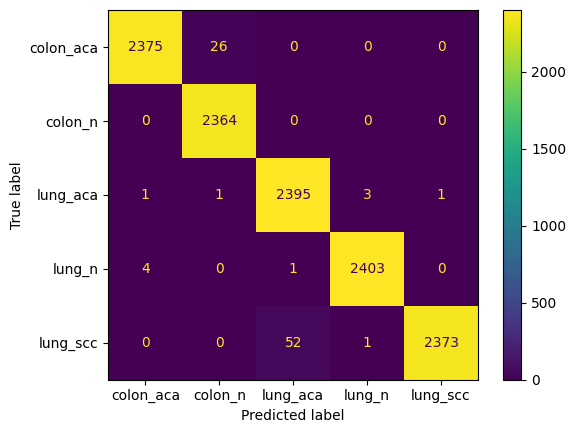

In [15]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [16]:
### test performace 

In [17]:
# get model predictions
y_pred = model.predict(X_test,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


375/375 [==============================] - 4s 11ms/step


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       599
           1       0.99      1.00      1.00       636
           2       0.97      0.99      0.98       599
           3       1.00      1.00      1.00       592
           4       0.99      0.97      0.98       574

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



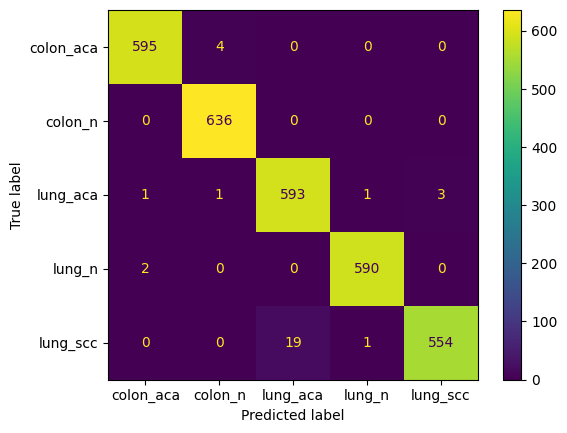

In [18]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [19]:
del(model)

### VGG 16

In [20]:
### initializing the model 
base_model = VGG16(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,849,349
Trainable params: 14,848,325
Non-trainable params: 1,024
______________________________________

In [21]:
### compiling the model
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

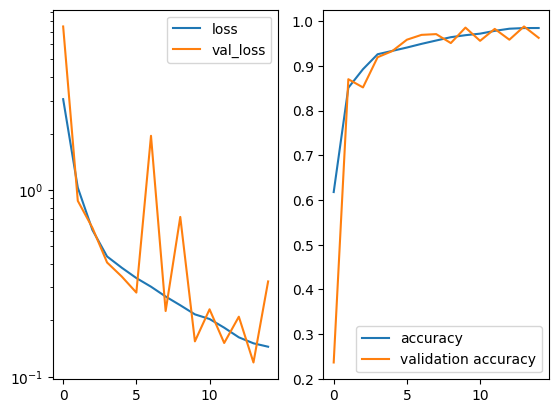

1200/1200 [==============================] - 151s 125ms/step - loss: 0.1445 - accuracy: 0.9845 - val_loss: 0.3232 - val_accuracy: 0.9625


In [22]:
history=model.fit(X_train,y_train,batch_size=8,validation_split=0.2,epochs=15,callbacks=accuracy_loss_plot)

In [23]:
### train performance

In [24]:
y_pred = model.predict(X_train,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

1500/1500 [==============================] - 50s 34ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2401
           1       0.99      1.00      0.99      2364
           2       1.00      0.88      0.94      2401
           3       1.00      0.99      1.00      2408
           4       0.90      1.00      0.95      2426

    accuracy                           0.97     12000
   macro avg       0.98      0.97      0.97     12000
weighted avg       0.98      0.97      0.97     12000



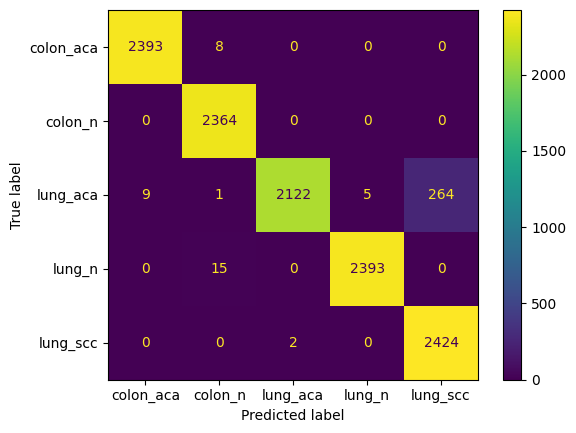

In [25]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [26]:
### test performace 

In [27]:
# get model predictions
y_pred = model.predict(X_test,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


375/375 [==============================] - 13s 34ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599
           1       0.99      1.00      1.00       636
           2       1.00      0.85      0.92       599
           3       1.00      0.99      1.00       592
           4       0.87      1.00      0.93       574

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



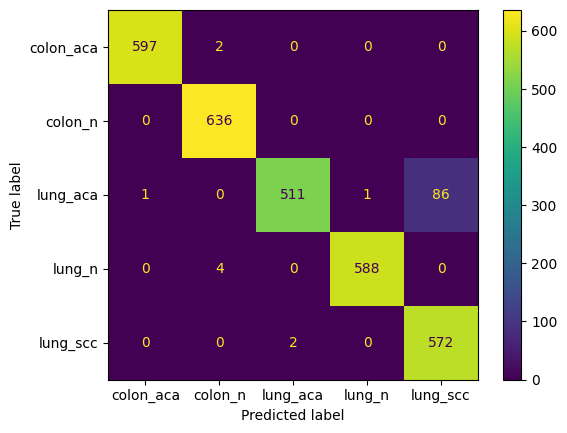

In [28]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [29]:
del(model)

### ResNet 50

In [30]:
### initializing the model 
base_model = ResNet50(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 24,121,733
Trainable params: 24,064,517
Non-trainable params: 57,216
_____________________________________

In [31]:
### compiling the model
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

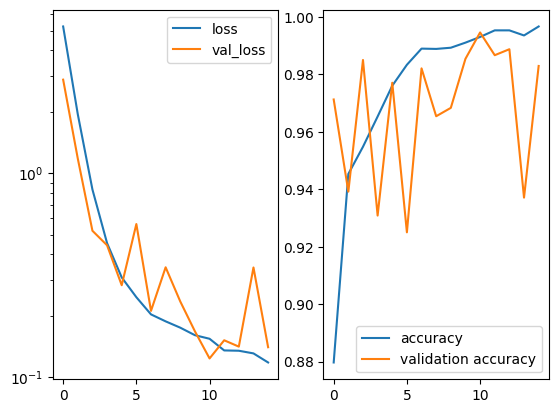

1200/1200 [==============================] - 140s 117ms/step - loss: 0.1182 - accuracy: 0.9967 - val_loss: 0.1404 - val_accuracy: 0.9829


In [32]:
history=model.fit(X_train,y_train,batch_size=8,validation_split=0.2,epochs=15,callbacks=accuracy_loss_plot)

In [33]:
### train performance

In [34]:
y_pred = model.predict(X_train,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

1500/1500 [==============================] - 46s 30ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2401
           1       1.00      1.00      1.00      2364
           2       1.00      0.98      0.99      2401
           3       1.00      1.00      1.00      2408
           4       0.98      1.00      0.99      2426

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



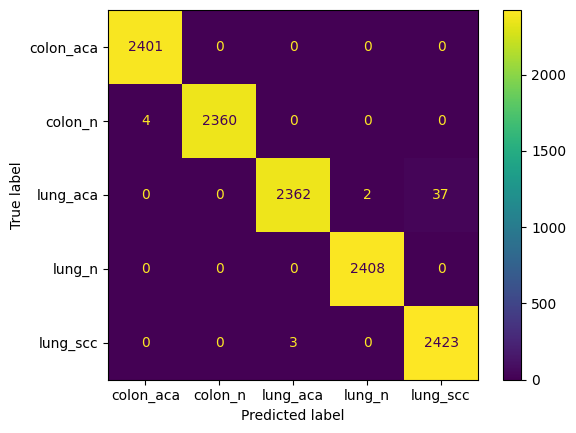

In [35]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [36]:
### test performace 

In [37]:
# get model predictions
y_pred = model.predict(X_test,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


375/375 [==============================] - 11s 30ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599
           1       1.00      1.00      1.00       636
           2       0.99      0.95      0.97       599
           3       1.00      1.00      1.00       592
           4       0.95      0.99      0.97       574

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



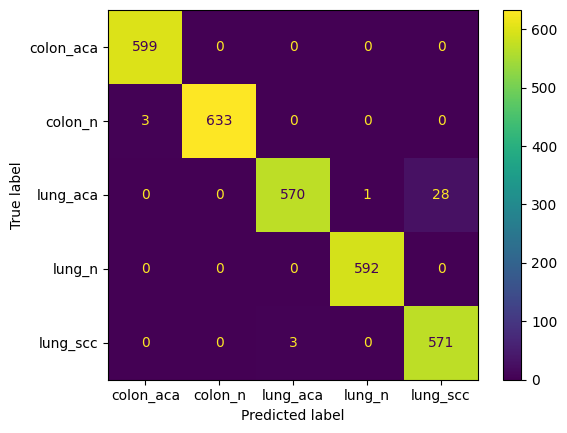

In [38]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [39]:
del(model)

### Vision Transformer B16

In [40]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

In [41]:
model = Sequential([
        vit_model,
        Flatten(),
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               196864    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

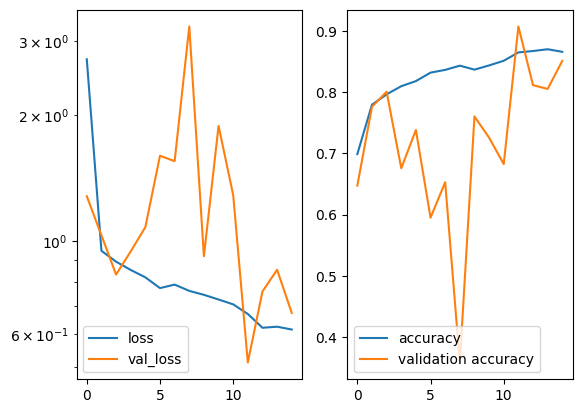

1200/1200 [==============================] - 433s 361ms/step - loss: 0.6149 - accuracy: 0.8660 - val_loss: 0.6737 - val_accuracy: 0.8512


In [43]:
history=model.fit(X_train,y_train,validation_split=0.2,epochs=15,batch_size=8, callbacks=accuracy_loss_plot)

In [44]:
### Train Performance

In [45]:
y_pred = model.predict(X_train,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

1500/1500 [==============================] - 169s 112ms/step


              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2401
           1       0.80      1.00      0.89      2364
           2       0.82      0.74      0.78      2401
           3       0.99      1.00      0.99      2408
           4       0.96      0.76      0.85      2426

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.88      0.87      0.87     12000



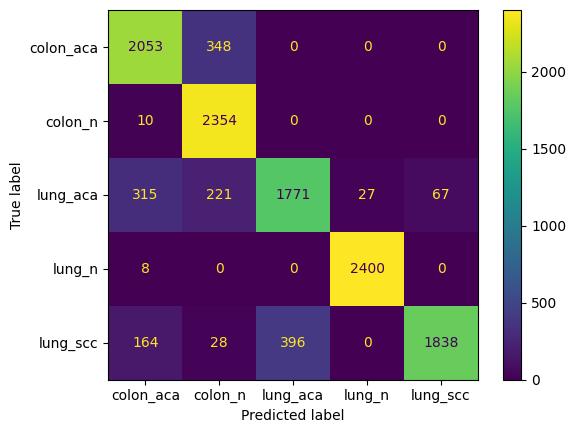

In [46]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [47]:
#### Test Perfornmance

In [48]:
# get model predictions
y_pred = model.predict(X_test,batch_size=8)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


375/375 [==============================] - 42s 113ms/step


              precision    recall  f1-score   support

           0       0.78      0.82      0.80       599
           1       0.77      0.99      0.87       636
           2       0.82      0.71      0.76       599
           3       0.98      0.99      0.99       592
           4       0.97      0.74      0.84       574

    accuracy                           0.85      3000
   macro avg       0.87      0.85      0.85      3000
weighted avg       0.86      0.85      0.85      3000



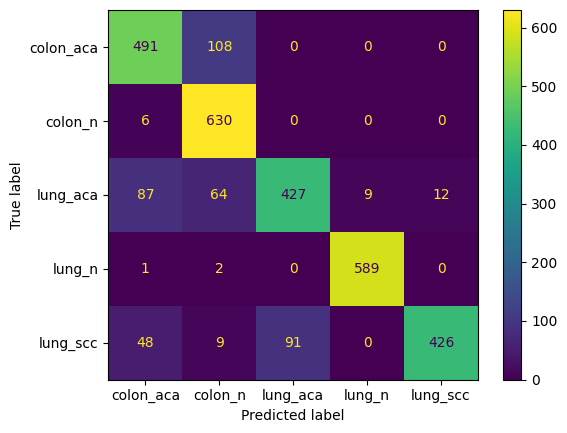

In [49]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()